In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io.wavfile import read, write
from scipy.signal import butter, filtfilt

In [39]:
# Load audio file
file_name = "jackhammer.wav"
Fs, data = read(file_name)
print(f"Sampling rate: {Fs} Hz")
print(f"Data type: {data.dtype}")
print(f"Data shape: {data.shape}")

Sampling rate: 44100 Hz
Data type: int16
Data shape: (147590, 2)


/var/folders/sm/bpqf8wpj6478c8rtz31k076r0000gn/T/ipykernel_73320/1874031768.py:3: WavFileWarning: Chunk (non-data) not understood, skipping it.
  Fs, data = read(file_name)


In [40]:
# Separate stereo channels
data_left_ch = data[:, 0]
data_right_ch = data[:, 1]

In [41]:
# Create time array
Ts = 1 / Fs
N = len(data_left_ch)
time = np.arange(0, N) * Ts

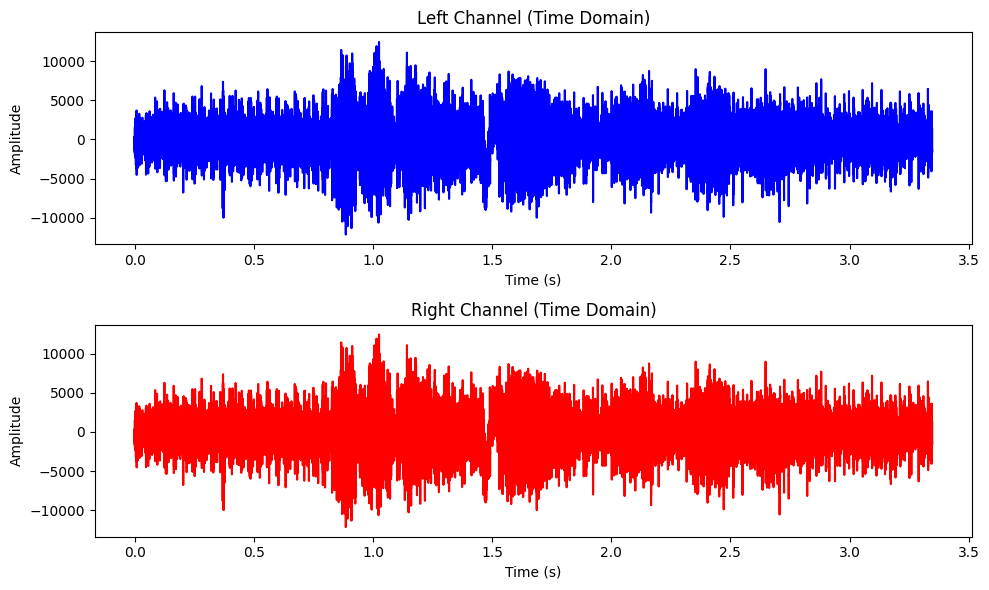

In [42]:
# Plot time-domain signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data_left_ch, "b")
plt.title("Left Channel (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(time, data_right_ch, "r")
plt.title("Right Channel (Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [43]:
# Compute FFT for frequency analysis
frequencies_left = np.fft.fft(data_left_ch)
frequencies_right = np.fft.fft(data_right_ch)
freq_axis = np.fft.fftfreq(N, Ts)[:N//2]  # Frequencies from 0 to Fs/2

# Normalize magnitude
magnitude_left = np.abs(frequencies_left[:N//2]) * 2 / N
magnitude_right = np.abs(frequencies_right[:N//2]) * 2 / N

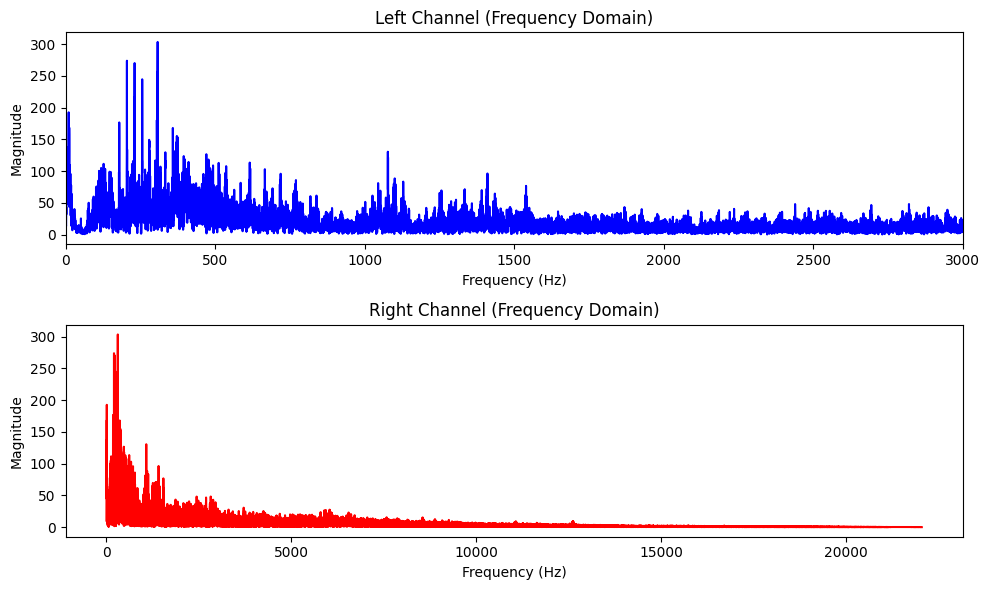

In [44]:
# Plot frequency-domain signals
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(freq_axis, magnitude_left, "b")
plt.title("Left Channel (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.xlim(0, 3000)

plt.subplot(2, 1, 2)
plt.plot(freq_axis, magnitude_right, "r")
plt.title("Right Channel (Frequency Domain)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [45]:
# High-pass filter to remove low-frequency noise
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data.astype(np.float32))  # Ensure data is float
    return y

In [46]:
# Apply high-pass filter
cutoff = 400  # Hz (adjust based on your analysis)
data_left_filtered = highpass_filter(data_left_ch, cutoff, Fs)
data_right_filtered = highpass_filter(data_right_ch, cutoff, Fs)

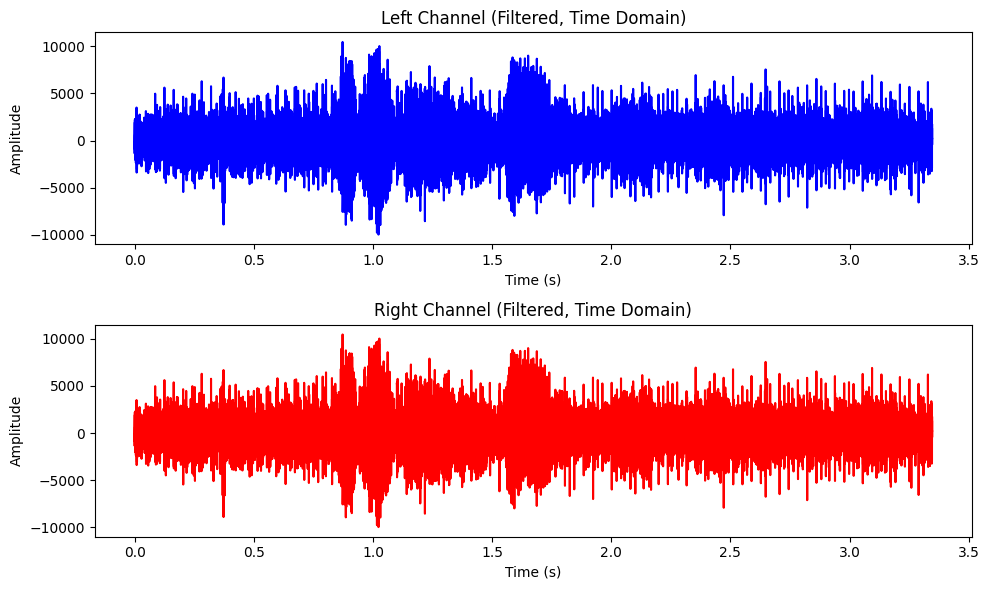

In [47]:
# Plot filtered signals in time domain
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data_left_filtered, "b")
plt.title("Left Channel (Filtered, Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(time, data_right_filtered, "r")
plt.title("Right Channel (Filtered, Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [48]:
# Spectral subtraction to further reduce noise
def spectral_subtraction(signal, noise, alpha=1.5):
    signal_fft = np.fft.fft(signal)
    noise_fft = np.fft.fft(noise)
    phase = np.angle(signal_fft)
    magnitude = np.abs(signal_fft)
    noise_power = np.abs(noise_fft) ** 2
    enhanced_magnitude = np.maximum(magnitude - alpha * np.sqrt(noise_power), 0)
    enhanced_fft = enhanced_magnitude * np.exp(1j * phase)
    enhanced_signal = np.fft.ifft(enhanced_fft).real
    return enhanced_signal

In [49]:
print(len(data_left_filtered), len(data_right_filtered))
print(len(data_left_ch[:int(0.5*Fs)]))

147590 147590
22050


In [50]:
# Assume first 0.5 seconds is noise-only
noise_segment = data_left_ch[:int(0.5 * Fs)]

# Pad or truncate noise_segment to match the length of data_left_filtered
if len(noise_segment) < len(data_left_filtered):
    padding_length = len(data_left_filtered) - len(noise_segment)
    noise_segment = np.pad(noise_segment, (0, padding_length), mode="constant")
else:
    noise_segment = noise_segment[: len(data_left_filtered)]  # Truncate if longer

# Perform spectral subtraction
data_left_enhanced = spectral_subtraction(data_left_filtered, noise_segment)
data_right_enhanced = spectral_subtraction(data_right_filtered, noise_segment)
data_left_enhanced = spectral_subtraction(data_left_filtered, noise_segment)
data_right_enhanced = spectral_subtraction(data_right_filtered, noise_segment)

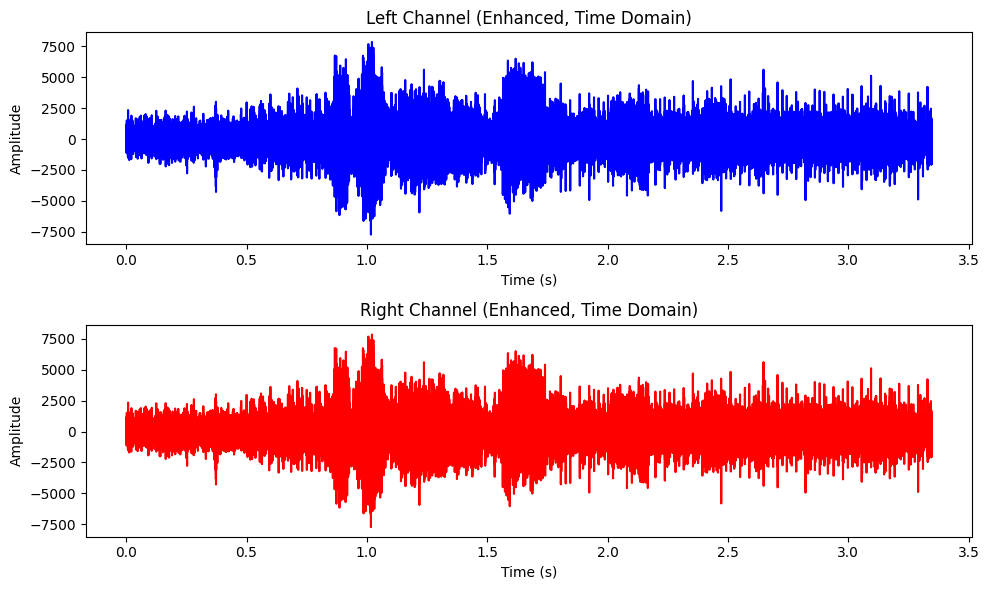

In [51]:
# Plot enhanced signals in time domain
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, data_left_enhanced, "b")
plt.title("Left Channel (Enhanced, Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.subplot(2, 1, 2)
plt.plot(time, data_right_enhanced, "r")
plt.title("Right Channel (Enhanced, Time Domain)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [52]:
# Save enhanced audio
enhanced_data = np.vstack((data_left_enhanced, data_right_enhanced)).T.astype(np.int16)
write("enhanced_audio.wav", Fs, enhanced_data)
print("Enhanced audio saved as 'enhanced_audio.wav'")

Enhanced audio saved as 'enhanced_audio.wav'
